# Multi-class Classification

We've referenced the TinyVGG architecture from the CNN Explainer website multiple times through this notebook, however, the CNN Explainer website works with 10 different image classes, where as our current model only works with two classes (pizza and steak).

> 🛠 **Practice:** Before scrolling down, how do you think we might change our model to work with 10 classes of the same kind of images? Assume the data is in the same style as our two class problem.

Remember the steps we took before to build our pizza 🍕 vs. steak 🥩 classifier?

How about we go through those steps again, except this time, we'll work with 10 different types of food.

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/misc-tensorflow-workflow-outline.png)
*The workflow we're about to go through is a slightly modified version of the above image. As you keep going through deep learning problems, you'll find the workflow above is more of an outline than a step-by-step guide.*

## 1. Import and become one with the data

Again, we've got a subset of the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101). In addition to the pizza and steak images, we've pulled out another eight classes.

In [5]:
# Download zip file of 10_food_classes images
# (Skip, load the data locally)

Now let's check out all of the different directories and sub-directories in the `10_food_classes` file.

In [6]:
import os

food_classes_dir = "data/image_data/food_classes"

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(food_classes_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data/image_data/food_classes'.
There are 10 directories and 0 images in 'data/image_data/food_classes/test'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/chicken_curry'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/chicken_wings'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/fried_rice'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/grilled_salmon'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/hamburger'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/ice_cream'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/pizza'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/ramen'.
There are 0 directories and 250 images in 'data/image_data/food_classes/test/steak'.
There are 0 directories and 250 images in 'data

Looking good!

We'll now setup the training and test directory paths.

In [7]:
train_dir = food_classes_dir + "/train/"
test_dir = food_classes_dir + "/test/"

And get the class names from the subdirectories.

In [8]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


How about we visualize an image from the training set?

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup target directory (we'll view images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off") # Turn off axis
    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (512, 384, 3)


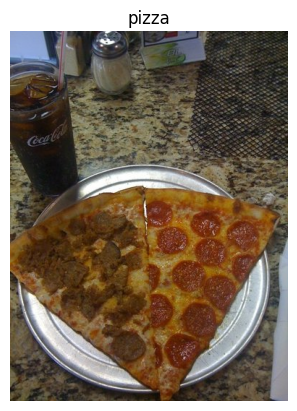

In [10]:
# View a random image from the training dataset
import random
img = view_random_image(
    target_dir=train_dir,
    target_class=random.choice(class_names) # get a random class name
)

## 2. Preprocess the data (prepare it for a model)

After going through a handful of images (it's good to visualize at least 10-100 different examples), it looks like our data directories are setup correctly.

Time to preprocess the data.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical' # changed to categorical
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

2024-12-18 08:09:29.426877: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 08:09:34.789829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 08:09:36.606069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 08:09:37.110878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 08:09:40.682998: I tensorflow/core/platform/cpu_feature_guar

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


As with binary classifcation, we've creator image generators. The main change this time is that we've changed the `class_mode` parameter to `'categorical'` because we're dealing with 10 classes of food images.

Everything else like rescaling the images, creating the batch size and target image size stay the same.

> 🤔 **Question:** Why is the image size 224x224? This could actually be any size we wanted, however, 224x224 is a very common size for preprocessing images to. Depending on your problem you might want to use larger or smaller images.

## 3. Create a model (start with a baseline)

We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:
* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the output layer to use `'softmax'` activation instead of `'sigmoid'` activation.
* Changing the loss function to be `'categorical_crossentropy'` instead of `'binary_crossentropy'`.

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

/mnt/d/Dev-Workspace/Python-workspace/tensorflow/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734480644.154367    2189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734480649.199858    2189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734480649.199918    2189 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:173448

### 4. Fit a model

Now we've got a model suited for working with multiple classes, let's fit it to our data.

In [13]:
# Fit the model
history_9 = model_9.fit(
    train_data, # now 10 different classes 
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5


/mnt/d/Dev-Workspace/Python-workspace/tensorflow/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734480757.498585    3972 service.cc:146] XLA service 0x7fdf34016c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734480757.498681    3972 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-12-18 08:12:37.906087: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-18 08:12:38.771999: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531

  1/235 ━━━━━━━━━━━━━━━━━━━━ 1:13:36 19s/step - accuracy: 0.0938 - loss: 2.3008

I0000 00:00:1734480771.522598    3972 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 166s 627ms/step - accuracy: 0.1812 - loss: 2.2102 - val_accuracy: 0.3040 - val_loss: 1.9969
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5


2024-12-18 08:15:18.207682: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 08:15:18.207822: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-12-18 08:15:18.216852: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-18 08:15:18.216953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous r

235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 242ms/step - accuracy: 0.3390 - loss: 1.8985 - val_accuracy: 0.3340 - val_loss: 1.8829
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 31us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5


2024-12-18 08:16:16.246747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4190402163046508785
2024-12-18 08:16:16.246885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4715320938962175495
2024-12-18 08:16:16.250242: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-18 08:16:16.250303: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4190402163046508785
2024-12-18 08:16:16.250338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4715320938962175495


235/235 ━━━━━━━━━━━━━━━━━━━━ 112s 470ms/step - accuracy: 0.4489 - loss: 1.6307 - val_accuracy: 0.3476 - val_loss: 1.8879


Why do you think each epoch takes longer than when working with only two classes of images?

It's because we're now dealing with more images than we were before. We've got 10 classes with 750 training images and 250 validation images each totalling 10,000 images. Where as when we had two classes, we had 1500 training images and 500 validation images, totalling 2000.

The intuitive reasoning here is the more data you have, the longer a model will take to find patterns.